In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from math import sqrt
from sklearn.metrics import mean_squared_error

rcParams['figure.figsize'] = 14, 8

# Load Data

Data [Music Artists Recommender System](https://towardsdatascience.com/music-artist-recommender-system-using-stochastic-gradient-descent-machine-learning-from-scratch-5f2f1aae972c)

In [2]:
import requests

url1 = "https://raw.githubusercontent.com/cockles98/MachineLearning_from_Scratch/master/data/last_fm/user_artists.dat"
url2 = "https://raw.githubusercontent.com/cockles98/MachineLearning_from_Scratch/master/data/last_fm/artists.dat"
response1 = requests.get(url1)
response2 = requests.get(url2)

with open("user_artists.dat", "wb") as file:
    file.write(response1.content)
    
with open("artists.dat", "wb") as file:
    file.write(response2.content)
    
df_user_artists = pd.read_csv("user_artists.dat", sep='\t')
df_artists = pd.read_csv("artists.dat", sep='\t', usecols=['id','name'])

In [3]:
plays = df_user_artists.rename(columns={"weight": "playCount"})
artists = df_artists

In [4]:
plays.head()

,userID,artistID,playCount
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [5]:
artists.head()

,id,name
0,1,MALICE MIZER
1,2,Diary of Dreams
2,3,Carpathian Forest
3,4,Moi dix Mois
4,5,Bella Morte


# First Preprocessing

In [6]:
ap = pd.merge(
  artists, plays, 
  how="inner",
  left_on="id",
  right_on="artistID"
)

In [7]:
ap.head()

,id,name,userID,artistID,playCount
0,1,MALICE MIZER,34,1,212
1,1,MALICE MIZER,274,1,483
2,1,MALICE MIZER,785,1,76
3,2,Diary of Dreams,135,2,1021
4,2,Diary of Dreams,257,2,152


In [8]:
artist_rank = ap.groupby(['name']) \
  .agg({'userID' : 'count', 'playCount' : 'sum'}) \
  .rename(columns={"userID" : 'totalUniqueUsers', "playCount" : "totalArtistPlays"}) \
  .sort_values(['totalArtistPlays'], ascending=False)

artist_rank['avgUserPlays'] = artist_rank['totalArtistPlays'] / artist_rank['totalUniqueUsers']

In [9]:
ap = ap.join(artist_rank, on="name", how="inner") \
  .sort_values(['playCount'], ascending=False)

In [10]:
ap.head()

,id,name,userID,artistID,playCount,totalUniqueUsers,totalArtistPlays,avgUserPlays
2800,72,Depeche Mode,1642,72,352698,282,1301308,4614.567376
35843,792,Thalía,2071,792,324663,26,350035,13462.884615
27302,511,U2,1094,511,320725,185,493024,2664.994595
8152,203,Blur,1905,203,257978,114,318221,2791.412281
26670,498,Paramore,1664,498,227829,399,963449,2414.659148


# Exploration

In [11]:
def bar_chart_int(x, y, x_label, y_label, title, caption, total_val, num_bars=20):
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 5)
    ax = sns.barplot(x=x[:num_bars], y=y[:num_bars], palette='Blues_r')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: '{:,}'.format(int(x))))

    # our bar label placement
    for p in ax.patches:
        height = p.get_height()
        pct = 100*(height/total_val)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.1f}%'.format(pct),
                ha="center",verticalalignment='bottom',color='black', fontsize=12)
        
    # our caption statement
    ax.text(19, max(y[:20])*0.95, caption,horizontalalignment='right')

    #plt.figtext(0.9, 0.01, caption, ha="right", fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

In [12]:
artist_rank.head()

,totalUniqueUsers,totalArtistPlays,avgUserPlays
name,,,
Britney Spears,522,2393140,4584.559387
Depeche Mode,282,1301308,4614.567376
Lady Gaga,611,1291387,2113.563011
Christina Aguilera,407,1058405,2600.503686
Paramore,399,963449,2414.659148


In [13]:
ap.head()

,id,name,userID,artistID,playCount,totalUniqueUsers,totalArtistPlays,avgUserPlays
2800,72,Depeche Mode,1642,72,352698,282,1301308,4614.567376
35843,792,Thalía,2071,792,324663,26,350035,13462.884615
27302,511,U2,1094,511,320725,185,493024,2664.994595
8152,203,Blur,1905,203,257978,114,318221,2791.412281
26670,498,Paramore,1664,498,227829,399,963449,2414.659148


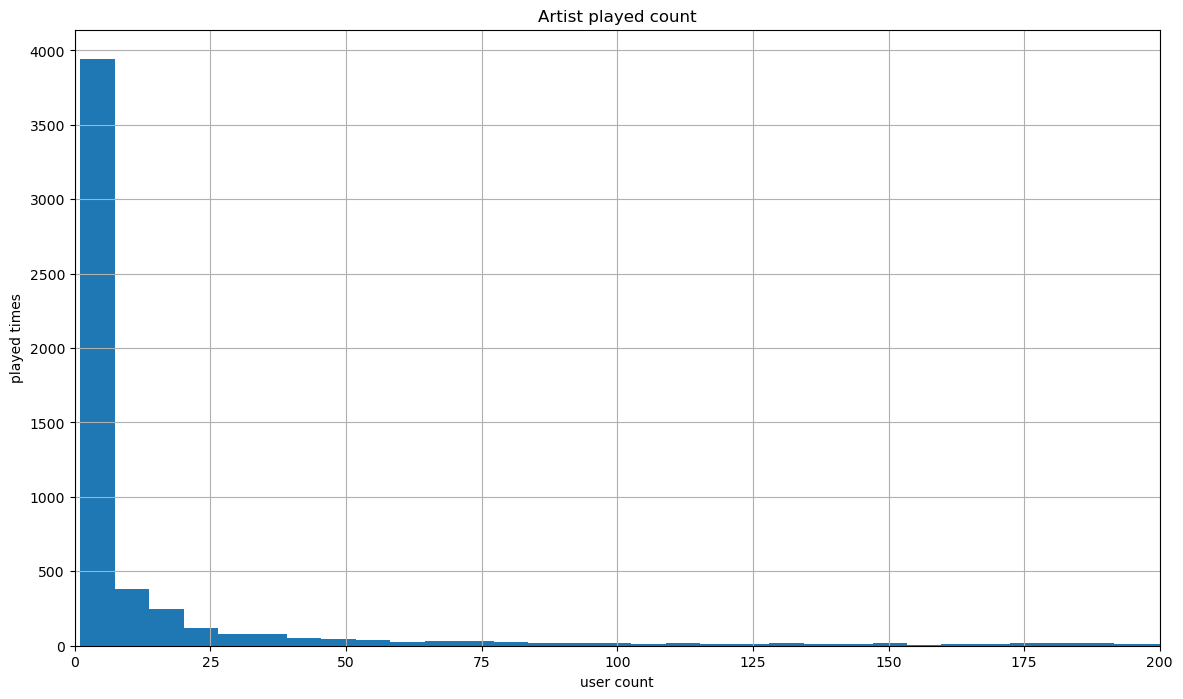

In [14]:
ax = ap.playCount.value_counts().hist(bins=100)
ax.set_xlim((0, 200))
ax.set_title("Artist played count")
ax.set_xlabel("user count")
ax.set_ylabel("played times");

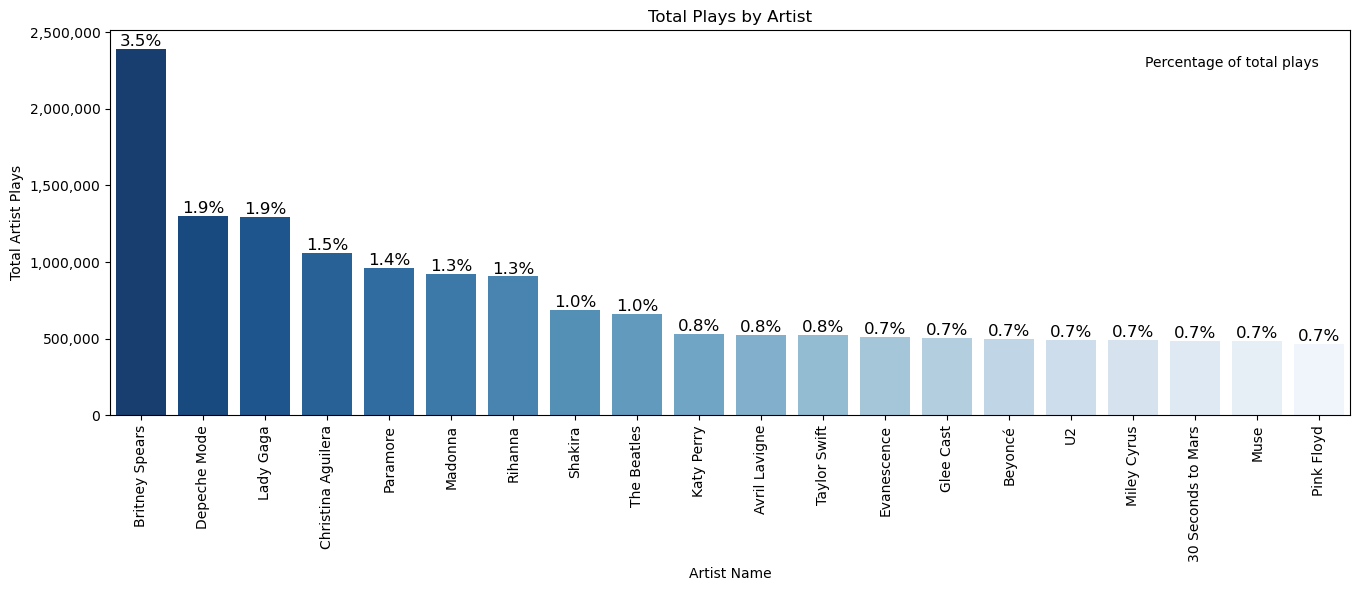

In [15]:
c1 = artist_rank
x = c1.index
y = c1.totalArtistPlays
x_label = 'Artist Name'
y_label = 'Total Artist Plays'
title = 'Total Plays by Artist'
caption = 'Percentage of total plays'
total_val = c1.totalArtistPlays.sum()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

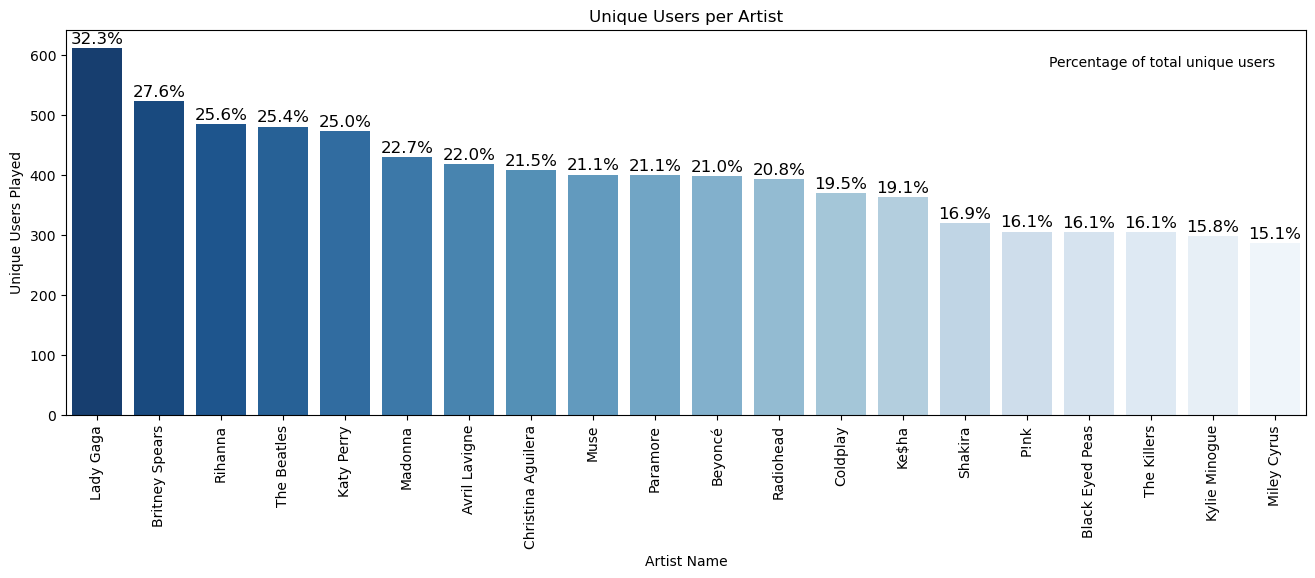

In [16]:
c2 = artist_rank.sort_values(['totalUniqueUsers'],ascending=False)
x = c2.index
y = c2.totalUniqueUsers
x_label = 'Artist Name'
y_label = 'Unique Users Played'
title = 'Unique Users per Artist'
caption = 'Percentage of total unique users'
total_val = ap.userID.nunique()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

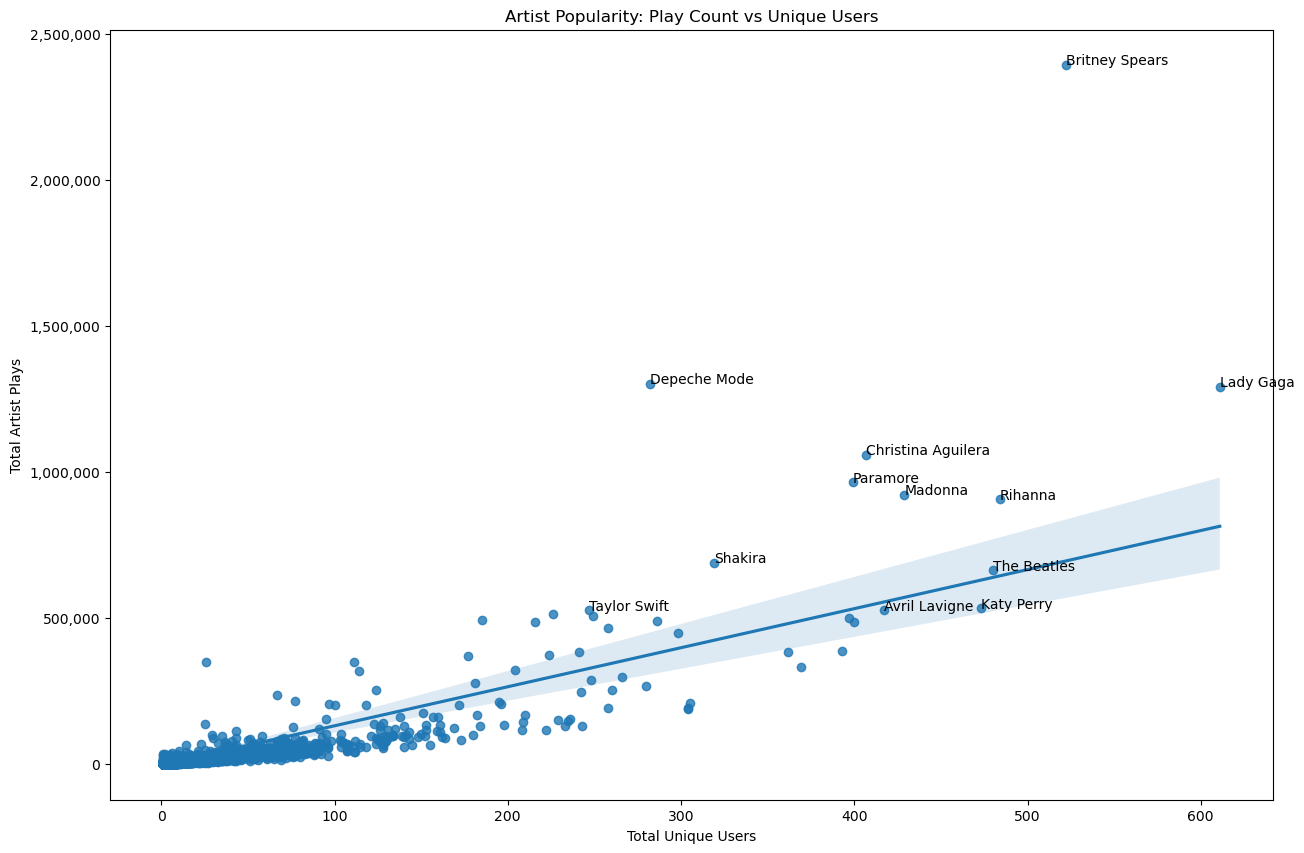

In [17]:
top_artists = artist_rank.sort_values(['totalArtistPlays'],ascending=False).index[:12]

x = artist_rank.totalUniqueUsers
y = artist_rank.totalArtistPlays
labels = artist_rank.index

fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x=x,y=y, ax=ax)
ax.set_title('Artist Popularity: Play Count vs Unique Users')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:,.0f}'.format(y)))
ax.set_xlabel('Total Unique Users')
ax.set_ylabel('Total Artist Plays')

for i, t in enumerate(labels):
    if t in top_artists:
        ax.annotate(t,(x[i],y[i]))

# Second Preprocessing

In [18]:
pc = ap.playCount
play_count_scaled = (pc - pc.min()) / (pc.max() - pc.min())

ap = ap.assign(playCountScaled=play_count_scaled)

In [19]:
ratings_df = ap.pivot(
    index='userID', 
    columns='artistID', 
    values='playCountScaled'
)

In [20]:
ratings = ratings_df.fillna(0).values

In [21]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('{:.2f}%'.format(sparsity))

0.28%


In [22]:
MIN_USER_RATINGS = 35
DELETE_RATING_COUNT = 15

def train_test_split(ratings):
    
    validation = np.zeros(ratings.shape)
    train = ratings.copy()
    
    for user in np.arange(ratings.shape[0]):
        if len(ratings[user,:].nonzero()[0]) >= MIN_USER_RATINGS:
            val_ratings = np.random.choice(
                ratings[user, :].nonzero()[0], 
                size=DELETE_RATING_COUNT,
                replace=False
            )
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]
    return train, validation

In [23]:
train, val = train_test_split(ratings)

In [24]:
train.shape

(1892, 17632)

# Recommender System

In [25]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [26]:
class Recommender:
  
    def __init__(self, n_epochs=200, n_latent_features=3, lmbda=0.1, learning_rate=0.001):
        self.n_epochs = n_epochs
        self.n_latent_features = n_latent_features
        self.lmbda = lmbda
        self.learning_rate = learning_rate

    def predictions(self, P, Q):
        return np.dot(P.T, Q)

    def fit(self, X_train, X_val):
        m, n = X_train.shape

        self.P = 3 * np.random.rand(self.n_latent_features, m)
        self.Q = 3 * np.random.rand(self.n_latent_features, n)

        self.train_error = []
        self.val_error = []

        users, items = X_train.nonzero()

        for epoch in range(self.n_epochs):
            for u, i in zip(users, items):
                error = X_train[u, i] - self.predictions(self.P[:,u], self.Q[:,i])
                self.P[:, u] += self.learning_rate * (error * self.Q[:, i] - self.lmbda * self.P[:, u])
                self.Q[:, i] += self.learning_rate * (error * self.P[:, u] - self.lmbda * self.Q[:, i])

            train_rmse = rmse(self.predictions(self.P, self.Q), X_train)
            val_rmse = rmse(self.predictions(self.P, self.Q), X_val)
            self.train_error.append(train_rmse)
            self.val_error.append(val_rmse)

        return self
  
    def predict(self, X_train, user_index):
        y_hat = self.predictions(self.P, self.Q)
        predictions_index = np.where(X_train[user_index, :] == 0)[0]
        return y_hat[user_index, predictions_index].flatten()

In [27]:
recommender = Recommender().fit(train, val)

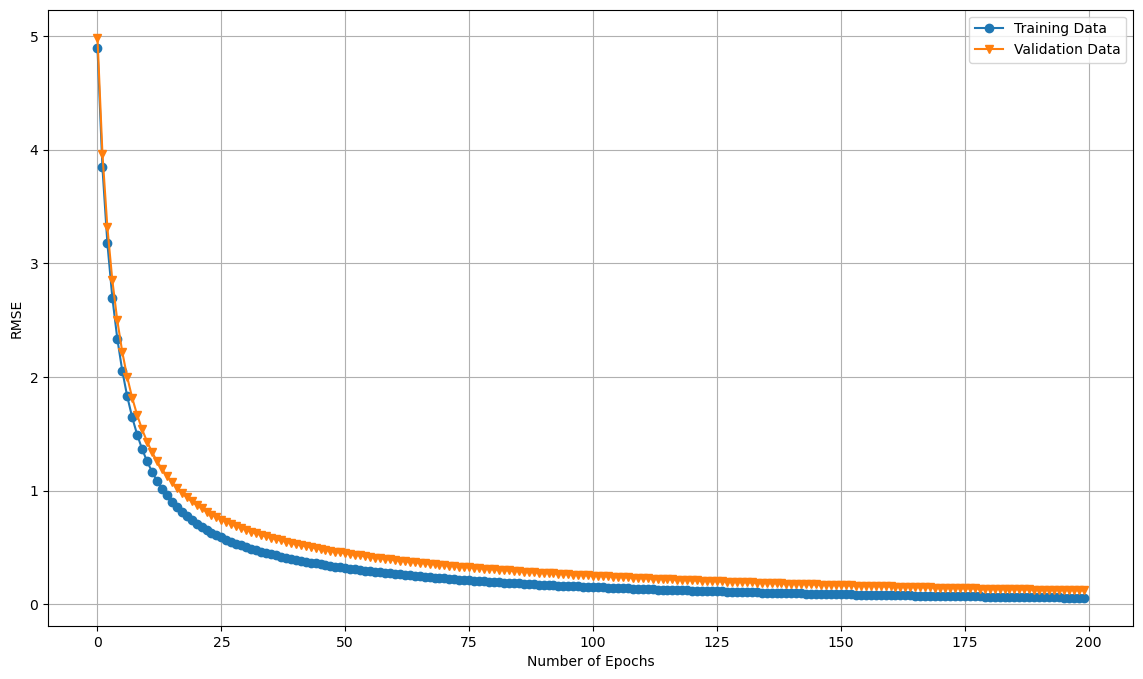

In [28]:
plt.plot(range(recommender.n_epochs), recommender.train_error, marker='o', label='Training Data');
plt.plot(range(recommender.n_epochs), recommender.val_error, marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

# Making recommendations

In [29]:
user_id = 1236
user_index = ratings_df.index.get_loc(user_id)
predictions_index = np.where(train[user_index, :] == 0)[0]

rating_predictions = recommender.predict(train, user_index)

In [30]:
def create_artist_ratings(artists_df, artists_index, ratings, n=10):
    artist_ids = ratings_df.columns[artists_index]
    artist_ratings = pd.DataFrame(data=dict(artistId=artist_ids, rating=ratings))
    top_n_artists = artist_ratings.sort_values("rating", ascending=False).head(n)

    artist_recommendations = artists_df[artists_df.id.isin(top_n_artists.artistId)].reset_index(drop=True)
    artist_recommendations['rating'] = pd.Series(top_n_artists.rating.values)
    return artist_recommendations.sort_values("rating", ascending=False)

In [31]:
existing_ratings_index = np.where(train[user_index, :] > 0)[0]
existing_ratings = train[user_index, existing_ratings_index]

create_artist_ratings(artists, existing_ratings_index, existing_ratings)

,id,name,rating
0,7,Marilyn Manson,0.052734
1,475,Eminem,0.043204
2,923,Children of Bodom,0.042016
3,978,Disturbed,0.029742
4,1104,Rammstein,0.029031
5,1118,A Perfect Circle,0.025657
6,1131,Tool,0.021690
7,2172,Gojira,0.020879
8,2479,Twiztid,0.017051
9,6618,D12,0.016280


In [32]:
create_artist_ratings(artists, predictions_index, rating_predictions)

,id,name,rating
0,5843,Charles Bernstein,0.149512
1,6045,Wax Tailor,0.149325
2,7275,Carly Rae Jepsen,0.148913
3,8609,Соль Земли,0.147899
4,9475,Phemon,0.147477
5,10696,Tiesto pres. Alone In The Dark,0.146233
6,11766,Nana Caymmi,0.146026
7,13703,Dumas,0.145869
8,15602,The Actor,0.145527
9,18545,On Solid Ground,0.144963
